In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from karateclub.graph_embedding import Graph2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, learning_curve
from sklearn.metrics import *

from master_thesis.utils.plotting import *
from master_thesis.utils import *

In [2]:
SEED = 39
CAUSAL_COEFF_STRENGTH = 1.7
EMBEDDING_HIDDEN_DIM = 16

# Load EC networks into a netwokx dataset

In [3]:
networks_dir = "../../Datasets/NeuroFlicks/networks/"
# List of all networks
np_files = os.listdir(networks_dir)

# Get labels from file names
labels = np.array([np_file[4:7] == 'PAT' for np_file in np_files])

# Load all networks, and calculate mean score and std
np_matrices = [np.load(os.path.join(networks_dir, np_file))[1] for np_file in np_files]
score_mean, score_std = np.array(np_matrices).mean(), np.array(np_matrices).std()

# Binarize networks
np_networks = np_matrices > score_mean + CAUSAL_COEFF_STRENGTH * score_std

# Convert to networkx graphs
dataset = [nx.from_numpy_array(np_network, create_using=nx.DiGraph) for np_network in np_networks]

# Balance of control and patological samples
n_control = len(labels) - labels.sum()
n_patological = labels.sum()

# Print dataset info
print(f"No of control samples: {n_control}")
print(f"No of patological samples: {n_patological}")

No of control samples: 69
No of patological samples: 382


## Plot a few samples

In [4]:
np.random.seed(SEED)
indices = np.random.choice(len(dataset), size=8, replace=False)

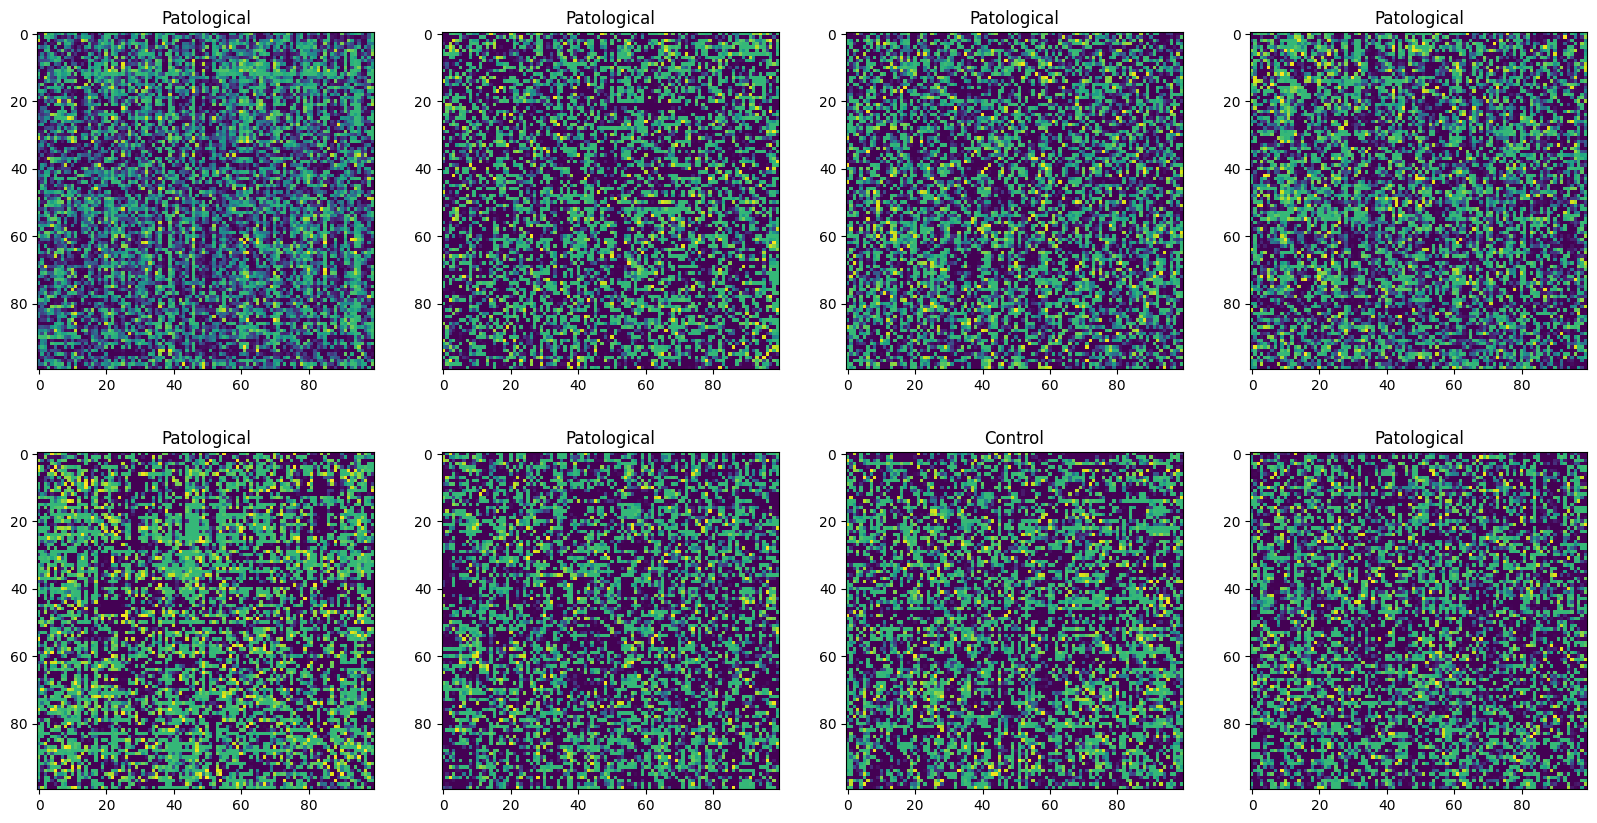

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in zip(indices, axes.flatten()):
    net = np_matrices[i]
    ax.imshow(net, cmap='viridis')
    ax.set_title("Patological" if labels[i] else "Control")

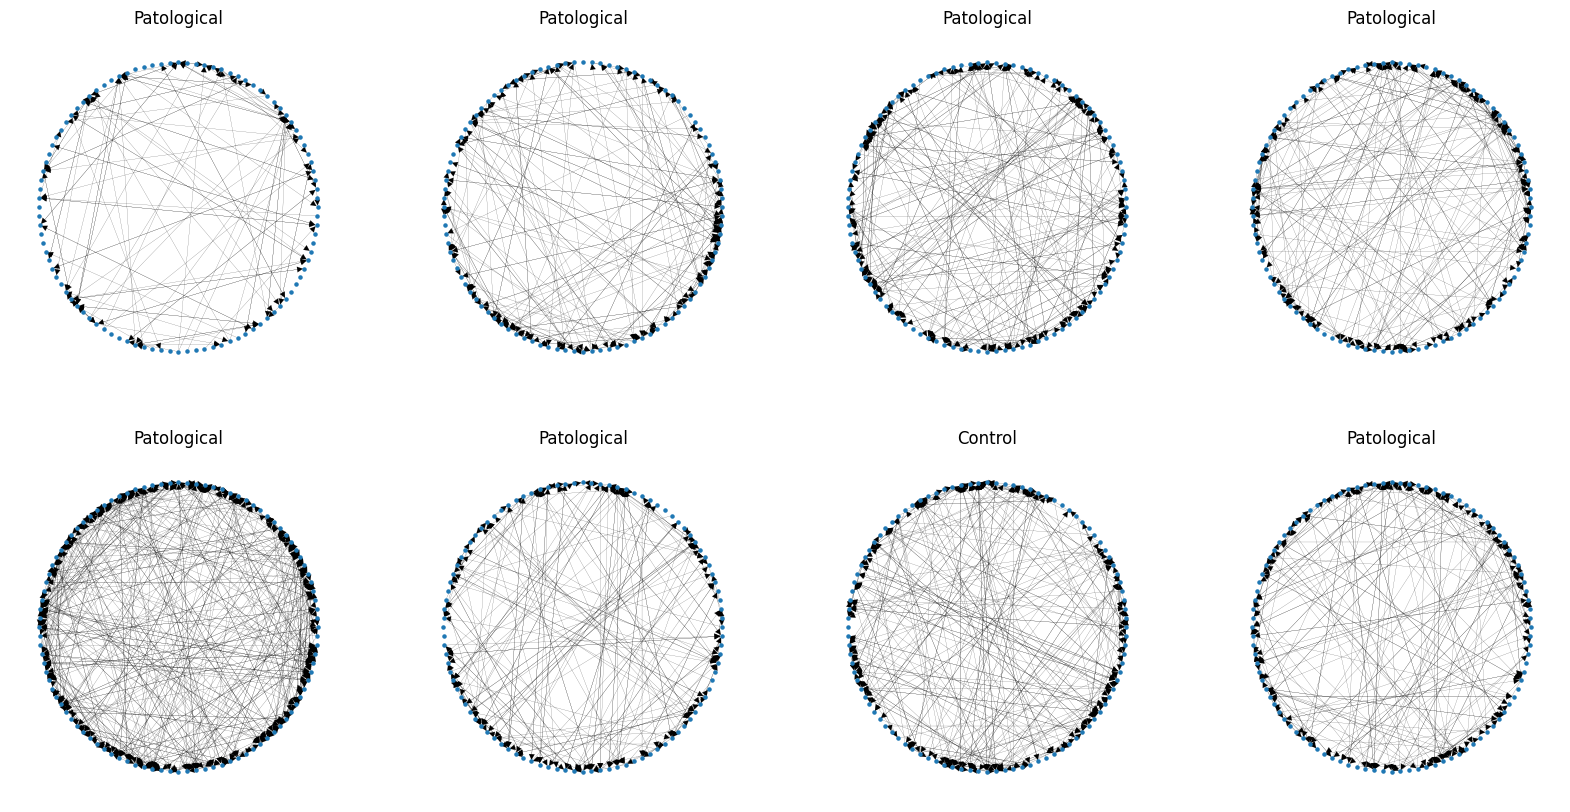

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, ax in zip(indices, axes.flatten()):
    net = dataset[i]
    nx.draw(net, ax=ax, pos=nx.circular_layout(net), node_size=5, width=0.1, with_labels=False)
    ax.set_title("Patological" if labels[i] else "Control")

# Class separation

## Embedd using graph2vec

In [7]:
model = Graph2Vec(dimensions=EMBEDDING_HIDDEN_DIM, wl_iterations=2, epochs=200, seed=SEED, workers=1)
model.fit(dataset)
embeddings = model.get_embedding()

## The dataset

In [8]:
print(f"No of control samples: {n_control}")
print(f"No of patological samples: {n_patological}")

No of control samples: 69
No of patological samples: 382


In [9]:
X_train, y_train, X_test, y_test = balance_split_dataset(embeddings, labels, half_test_size=20, verbose=True)

X_train shape: (724, 16), y_train shape: (724,)
X_test shape: (40, 16), y_test shape: (40,)
Ratio of positive samples in train: 0.5
Ratio of positive samples in test: 0.5


## Ridge regression

### Best parameters
- Graph2Vec(dimensions=16, wl_iterations=2, epochs=200)
- test_size: 0.3
- random_state: 42
- alpha: 100.0

### Results
- Train accuracy: 0.62, Test accuracy: 0.61
- Train recall: 0.85, Test recall: 0.89
- Train precision: 0.59, Test precision: 0.57
- Train f1: 0.69, Test f1: 0.70
- Confusion matrix: $$\begin{bmatrix}  3 & 6 \\  1 & 8 \end{bmatrix}$$

### Grid Search with cross validation
It does not seem to work. Always selecting lowest regularization, when scoring accuracy.

In [10]:
params = {'alpha': np.logspace(-1, 3, 17)}

clf = GridSearchCV(RidgeClassifier(), params, cv=5, scoring='f1', n_jobs=-1)
clf.fit(X_train, y_train)

print(f"Best params: {clf.best_params_}")
print(f"Best score: {clf.best_score_}")

Best params: {'alpha': 56.23413251903491}
Best score: 0.6560225466793459


Train accuracy: 0.67,		Test accuracy: 0.67
Train recall: 0.66, Test recall: 0.65
Train precision: 0.68, Test precision: 0.65
Train f1: 0.67, Test f1: 0.65
Train AUC: 0.67, Test AUC: 0.65


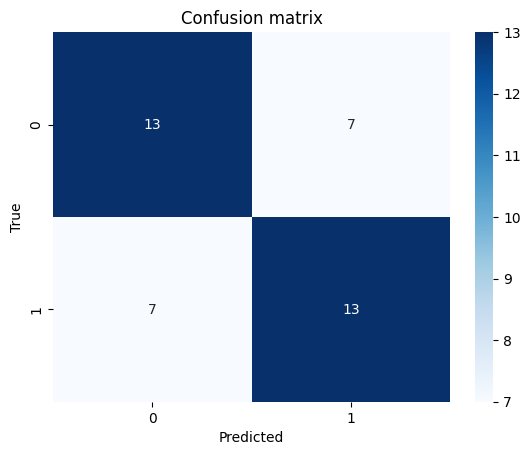

In [11]:
# Fit Ridge classifier
rc = RidgeClassifier(alpha=100.)
rc.fit(X_train, y_train)
y_train_hat, y_test_hat = rc.predict(X_train), rc.predict(X_test)

# Evaluate
evaluate(y_train, y_train_hat, y_test, y_test_hat)

## SVM Classifier

Train accuracy: 0.86,		Test accuracy: 0.86
Train recall: 0.81, Test recall: 0.65
Train precision: 0.90, Test precision: 0.59
Train f1: 0.85, Test f1: 0.62
Train AUC: 0.86, Test AUC: 0.60


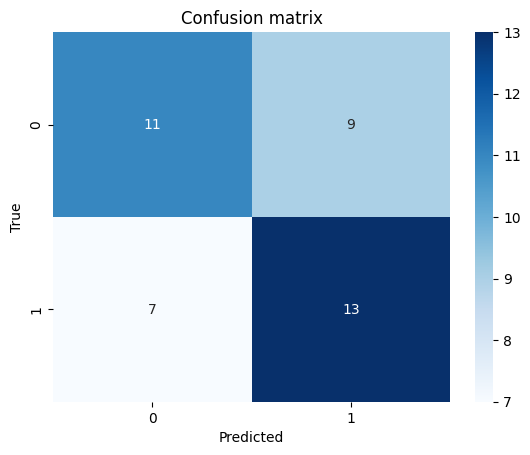

In [12]:
# Fit Ridge classifier
svc = SVC(kernel='rbf', C=0.2)
svc.fit(X_train, y_train)
y_train_hat, y_test_hat = svc.predict(X_train), svc.predict(X_test)

# Evaluate
evaluate(y_train, y_train_hat, y_test, y_test_hat)

## Random Forest

Train accuracy: 0.82,		Test accuracy: 0.82
Train recall: 0.82, Test recall: 0.80
Train precision: 0.83, Test precision: 0.55
Train f1: 0.82, Test f1: 0.65
Train AUC: 0.82, Test AUC: 0.57


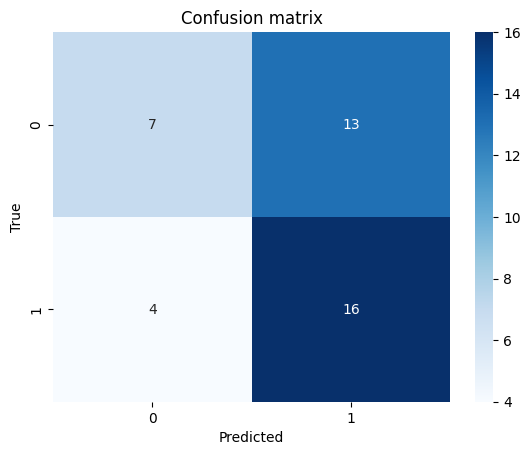

In [13]:
# Fit Ridge classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=2, min_samples_leaf=10, random_state=43, oob_score=False)
rf.fit(X_train, y_train)
y_train_hat, y_test_hat = rf.predict(X_train), rf.predict(X_test)

# Evaluate
evaluate(y_train, y_train_hat, y_test, y_test_hat)

## MLP Classifier

Train accuracy: 0.73,		Test accuracy: 0.73
Train recall: 0.70, Test recall: 0.65
Train precision: 0.75, Test precision: 0.76
Train f1: 0.72, Test f1: 0.70
Train AUC: 0.73, Test AUC: 0.73


/Users/wciezobka/venvs/sano/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


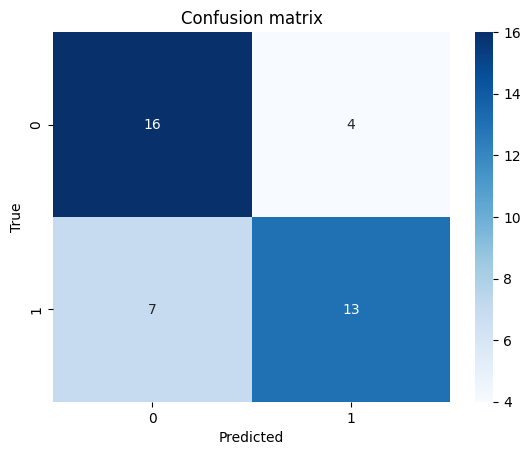

In [14]:
# Fit Ridge classifier
mlp = MLPClassifier(hidden_layer_sizes=(64), max_iter=10, random_state=SEED)
mlp.fit(X_train, y_train)
y_train_hat, y_test_hat = mlp.predict(X_train), mlp.predict(X_test)

# Evaluate
evaluate(y_train, y_train_hat, y_test, y_test_hat)

### MLP (torch)

In [15]:
import torch
from torch import nn

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [16]:
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

In [17]:
model = nn.Sequential(
    nn.Linear(EMBEDDING_HIDDEN_DIM, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
)
model.to(device)

loss_fn = nn.BCEWithLogitsLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred))
    return acc

In [18]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 20

loss_train = []
loss_test = []
metric = []
# Create training and testing loop
for epoch in tqdm(range(epochs)):
    ### Training
    # Add a loop to loop through training batches
    
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_logits, y_train)
    loss_train.append(loss.item())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # test_accuracy.append(accuracy_fn(y_test, test_pred))
        metric.append(test_pred[0].item())

        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        loss_test.append(test_loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]

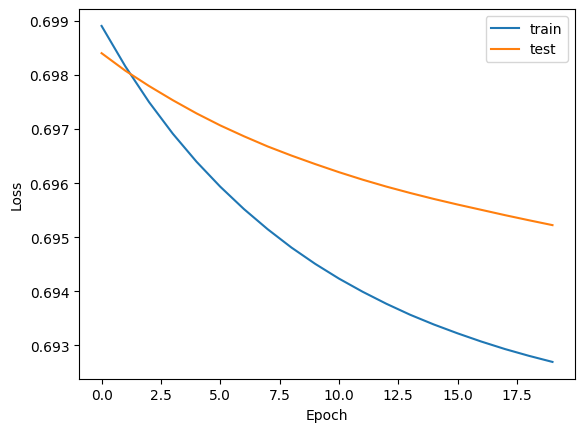

In [19]:
# Plot loss curves
plt.plot(loss_train, label='train')
plt.plot(loss_test, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

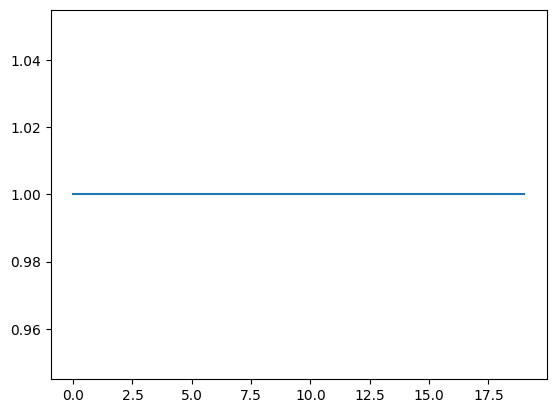

In [20]:
plt.plot(metric)